In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

Using TensorFlow backend.


In [2]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)

In [3]:
img_width, img_height = 16, 16

nb_epoch = 50
batch_size = 32

In [4]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'

train_data_dir      = base_dir + '/tiny_train16'
validation_data_dir = base_dir + '/tiny_validation16'
test_data_dir       = base_dir + '/tiny_test16'


nb_train_samples = 0
train_folders = os.listdir(train_data_dir)
train_folders.sort()
for folder in train_folders:
    nb_train_samples += len(os.listdir(train_data_dir + '/' + folder))
print(nb_train_samples)

nb_validation_samples = 0
validation_folders = os.listdir(validation_data_dir)
validation_folders.sort()
for folder in validation_folders:
    nb_validation_samples += len(os.listdir(validation_data_dir + '/' + folder))
print(nb_validation_samples)

157086
3932


In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

W0808 12:28:51.849468 140091106395968 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 12:28:51.869217 140091106395968 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 12:28:51.871705 140091106395968 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 12:28:51.881107 140091106395968 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0808 12:28:51.9233

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0         
__________

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255#,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True
        )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None)

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None)

Found 157086 images belonging to 1 classes.
Found 3932 images belonging to 1 classes.


In [7]:
model_version = 'alex_20190808_mid16'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


autoencoder.fit_generator(
        fixed_generator(train_generator),
        steps_per_epoch=nb_train_samples,
        epochs=nb_epoch,
        validation_data=fixed_generator(validation_generator),
        validation_steps=nb_validation_samples,
        callbacks=[checkpointer]
        )

autoencoder.save(base_dir + '/autoencoder' + model_version + '.h5')

# autoencoder = load_model(base_dir + '/autoencoder' + model_version + '.h5')

W0808 12:28:57.482905 140091106395968 deprecation_wrapper.py:119] From /scratch/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/50
157086/157086 [==============================] - 1269s 8ms/step - loss: 0.5259 - val_loss: 0.5174
Epoch 2/50
157086/157086 [==============================] - 1267s 8ms/step - loss: 0.5205 - val_loss: 0.5153
Epoch 3/50
157086/157086 [==============================] - 1266s 8ms/step - loss: 0.5197 - val_loss: 0.5161
Epoch 4/50
157086/157086 [==============================] - 1264s 8ms/step - loss: 0.5193 - val_loss: 0.5149
Epoch 5/50
157086/157086 [==============================] - 1259s 8ms/step - loss: 0.5187 - val_loss: 0.5156
Epoch 6/50
157086/157086 [==============================] - 1258s 8ms/step - loss: 0.5184 - val_loss: 0.5141
Epoch 7/50
157086/157086 [==============================] - 1260s 8ms/step - loss: 0.5183 - val_loss: 0.5146
Epoch 8/50
157086/157086 [==============================] - 1294s 8ms/step - loss: 0.5182 - val_loss: 0.5139
Epoch 9/50
157086/157086 [==============================] - 1275s 8ms/step - loss: 0.5182 - val_loss: 0.5151
Epoch 10/50
157086/

predictions: 


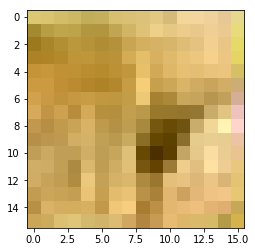

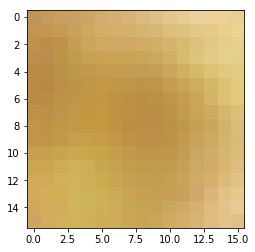

next


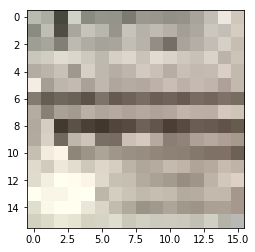

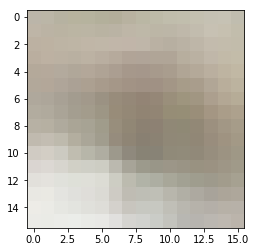

next


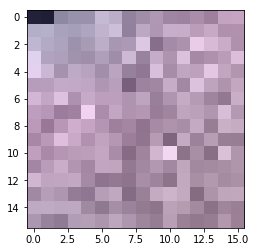

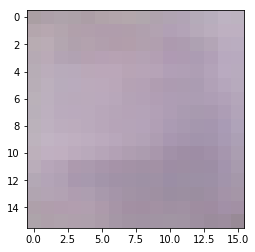

next


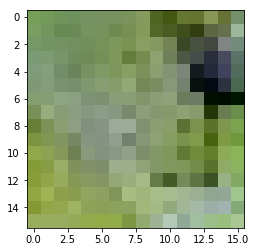

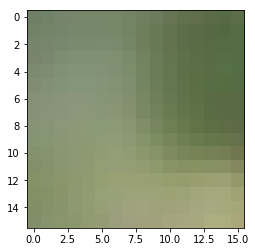

next


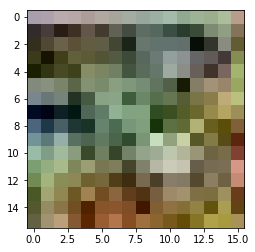

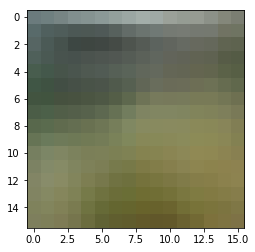

next


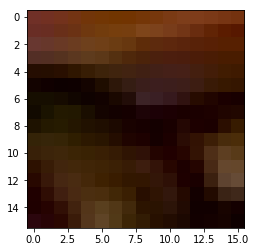

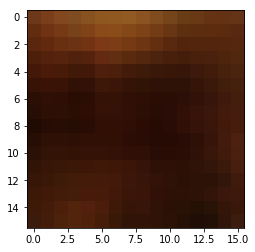

next


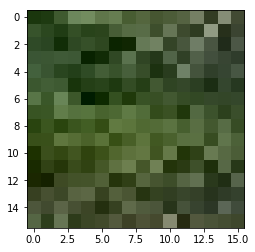

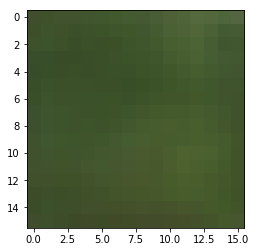

next


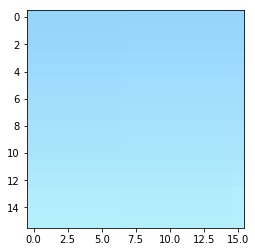

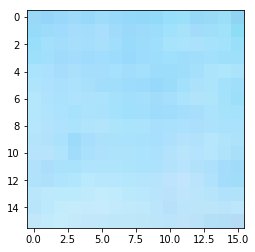

next


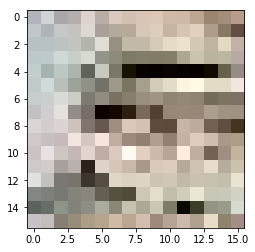

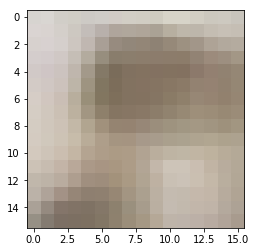

next


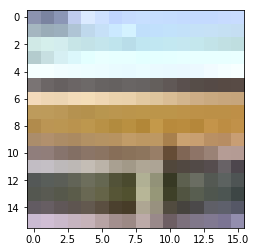

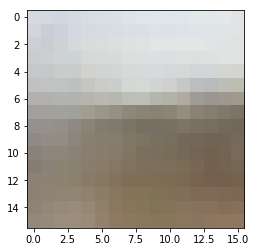

next


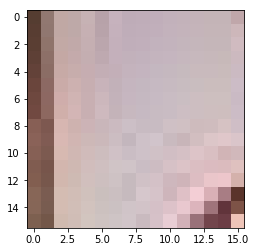

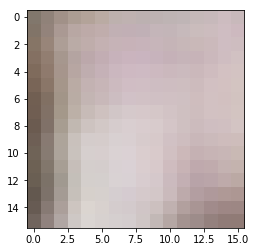

next


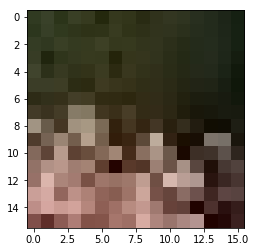

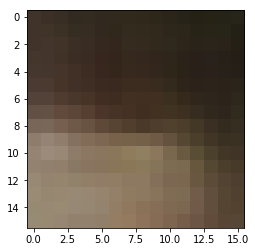

next


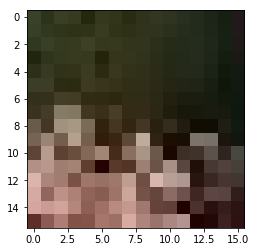

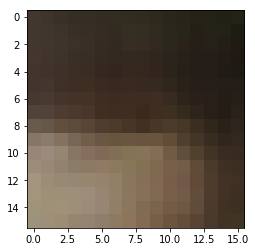

next


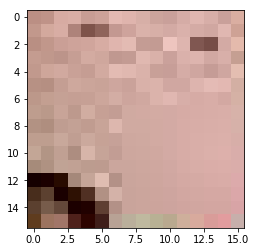

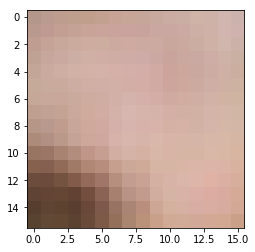

next


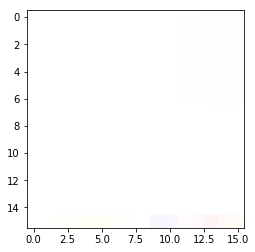

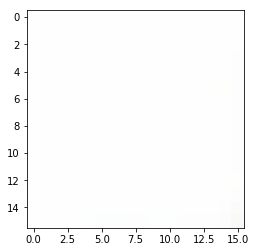

next


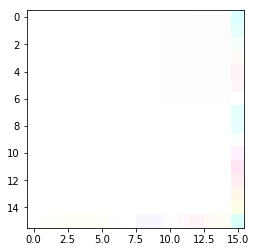

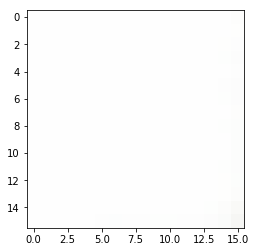

next


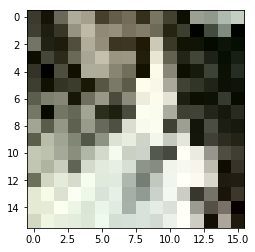

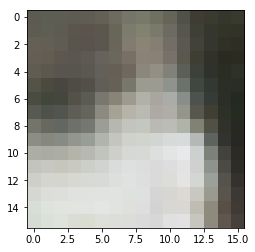

next


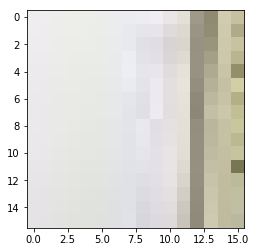

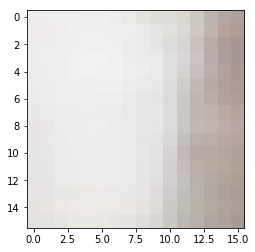

next


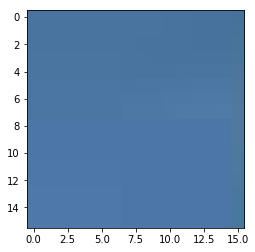

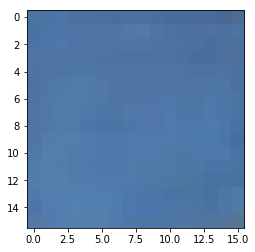

next


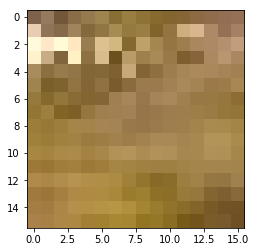

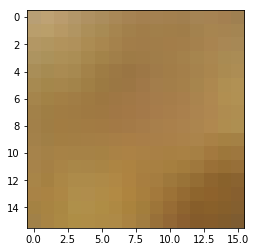

next


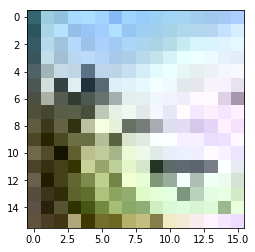

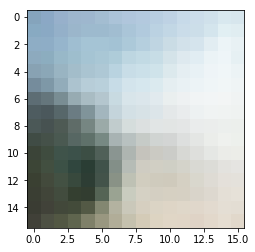

next


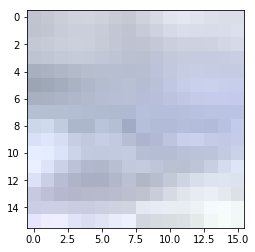

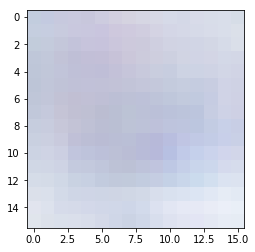

next


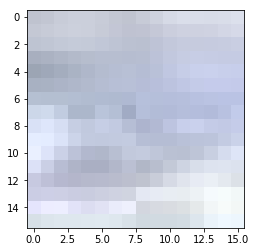

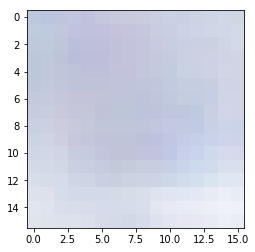

next


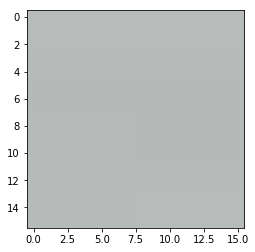

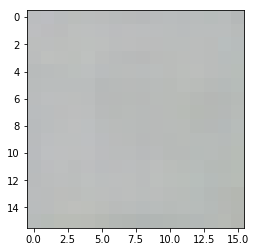

next


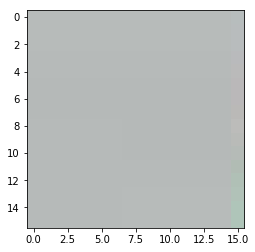

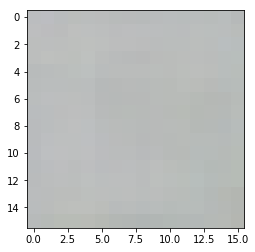

next


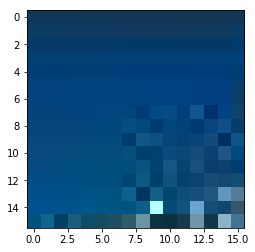

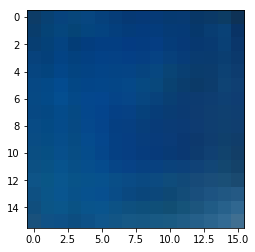

next


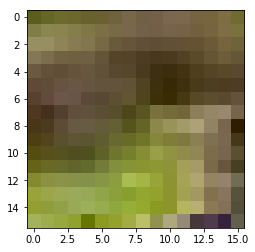

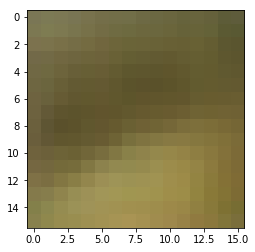

next


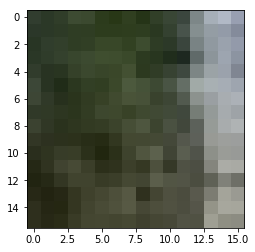

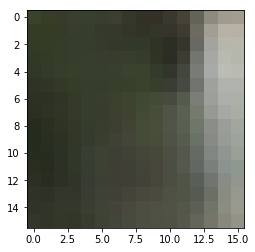

next


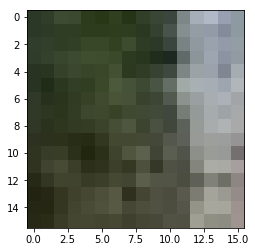

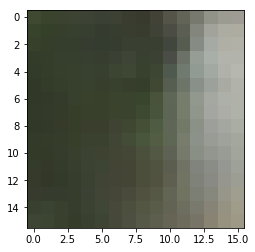

next


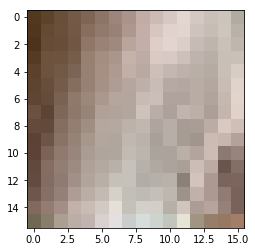

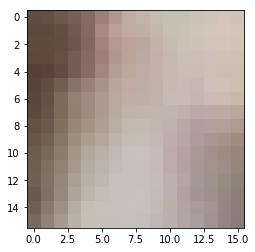

next


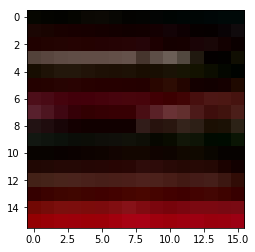

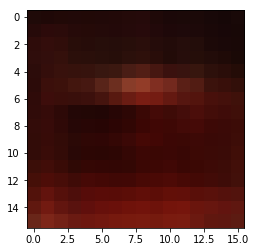

next


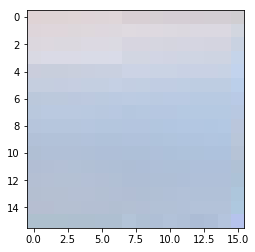

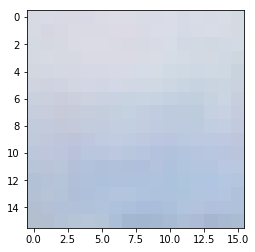

next


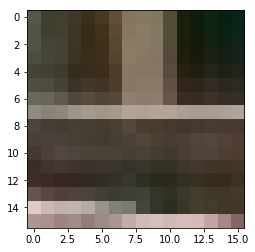

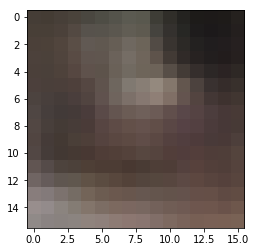

next


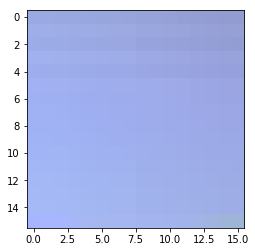

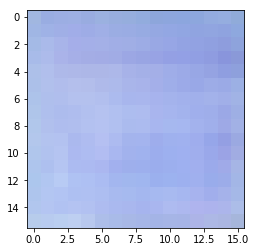

next


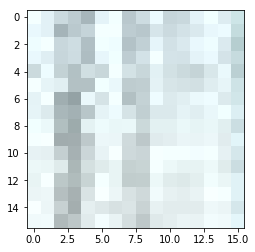

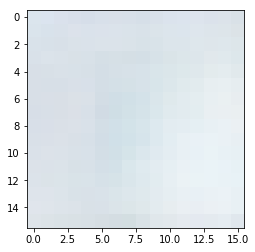

next


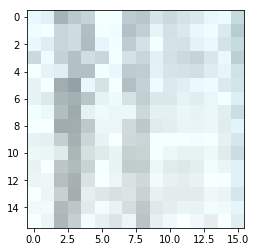

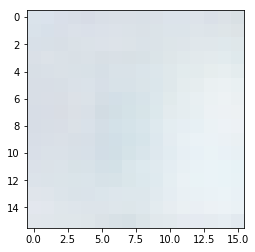

next


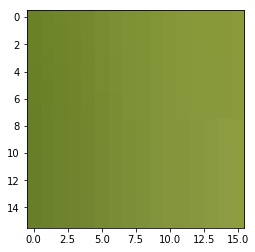

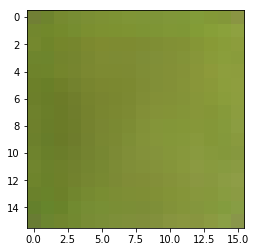

next


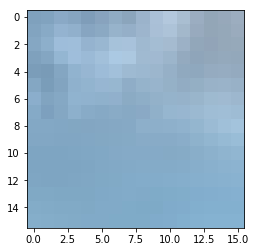

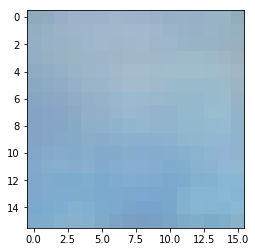

next


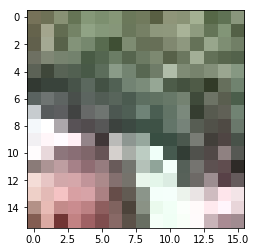

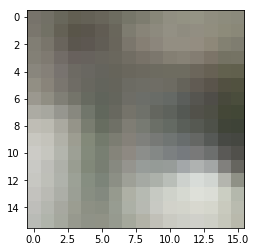

next


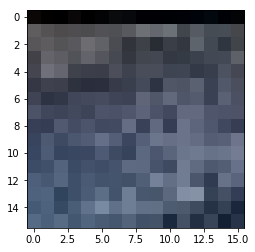

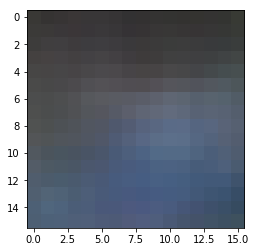

next


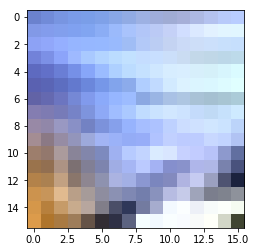

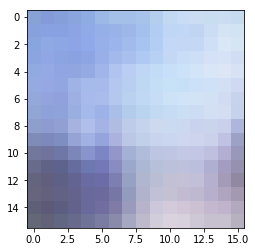

next


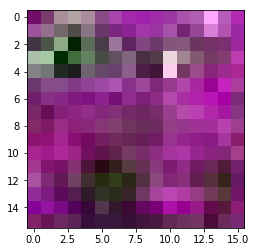

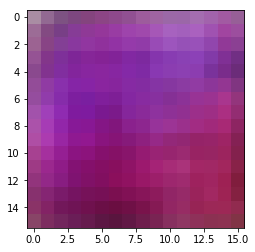

next


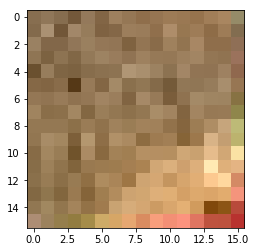

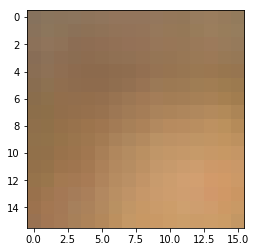

next


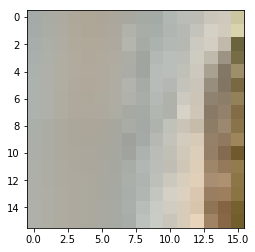

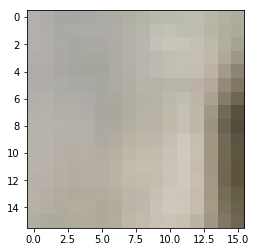

next


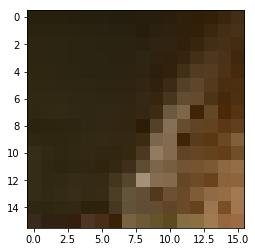

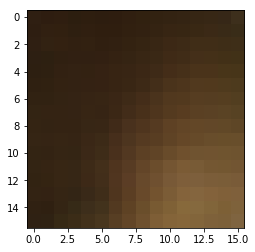

next


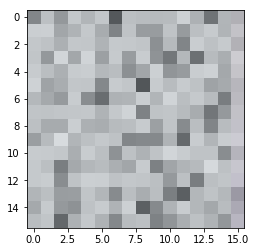

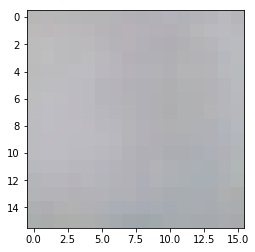

next


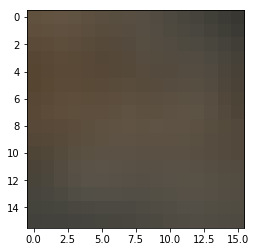

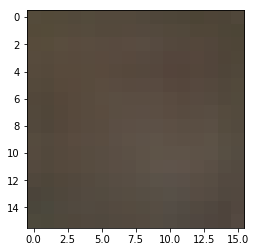

next


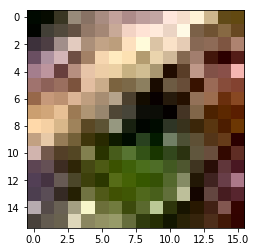

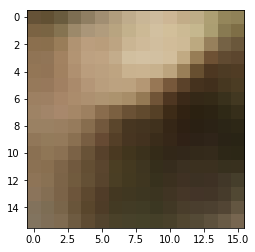

next


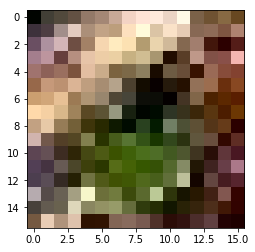

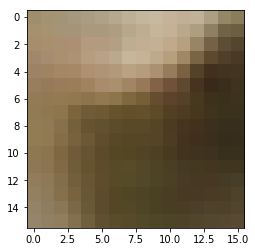

next


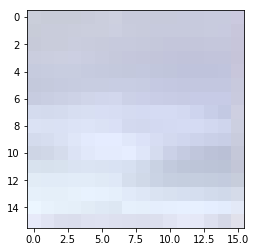

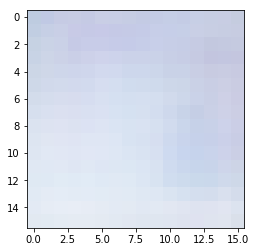

next


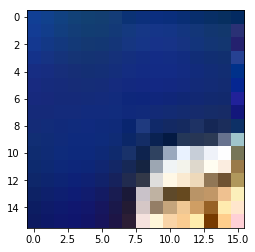

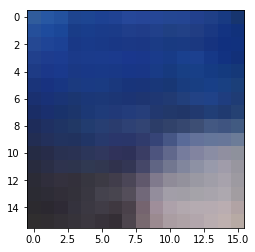

next


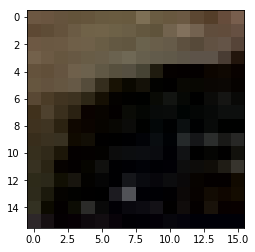

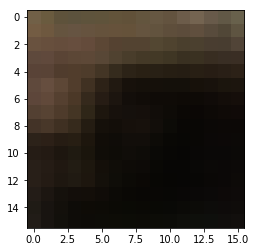

next


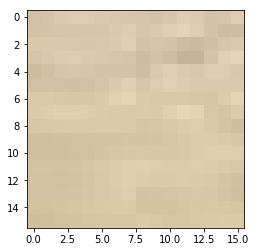

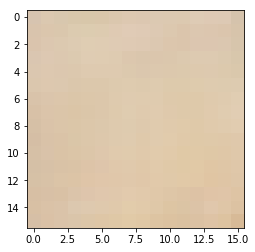

next


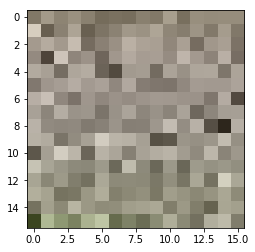

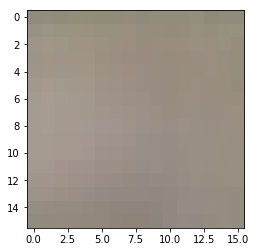

next


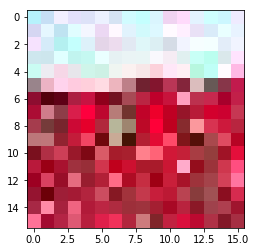

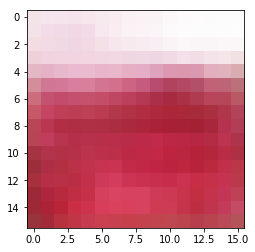

next


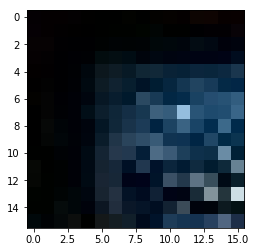

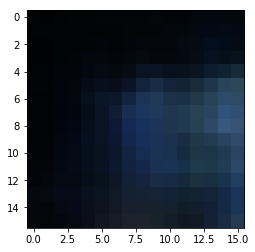

next


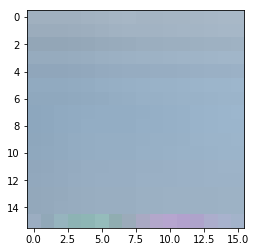

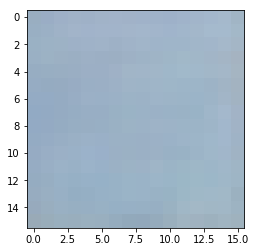

next


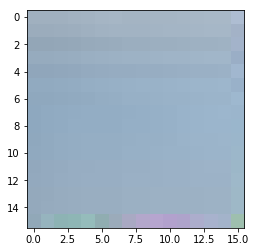

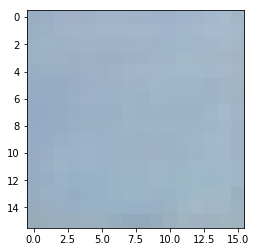

next


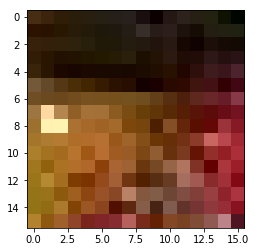

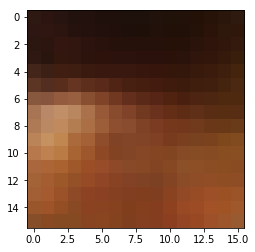

next


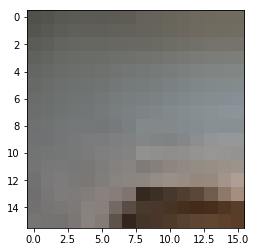

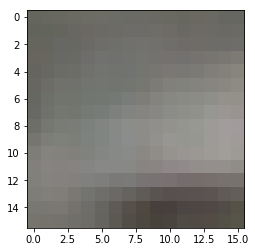

next


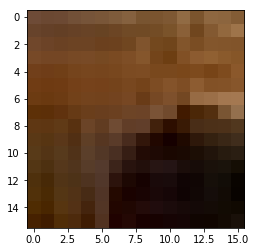

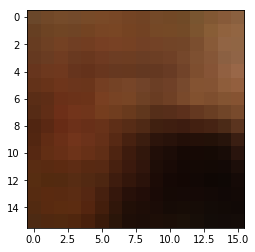

next


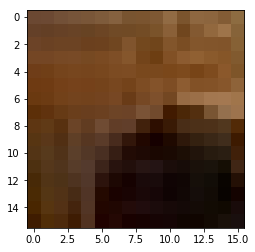

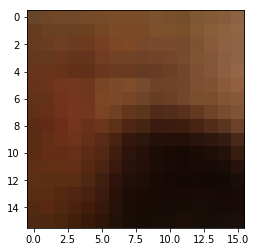

next


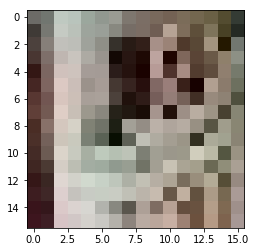

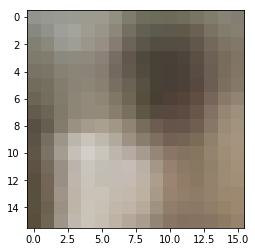

next


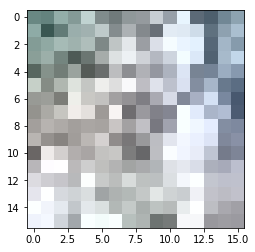

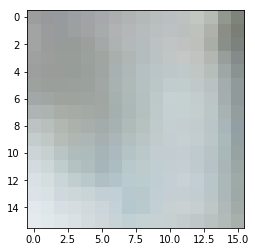

next


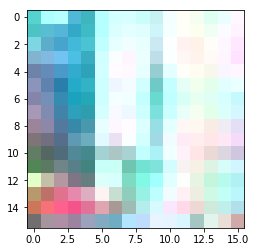

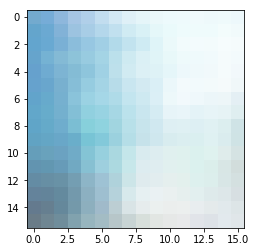

next


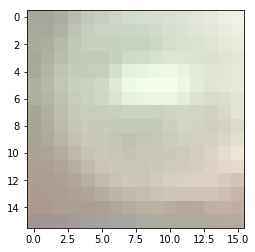

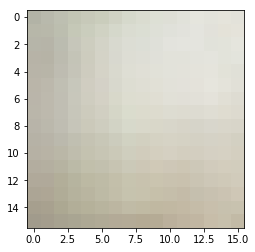

next


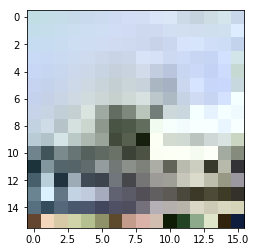

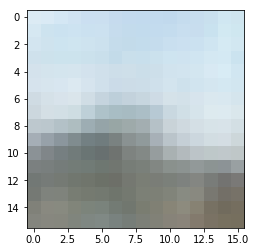

next


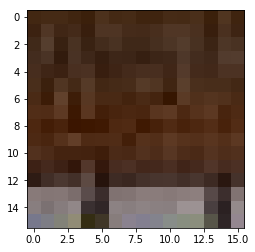

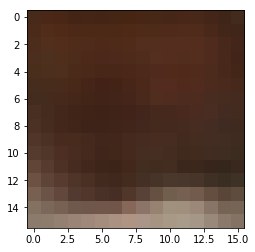

next


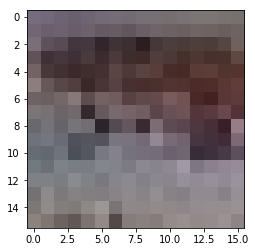

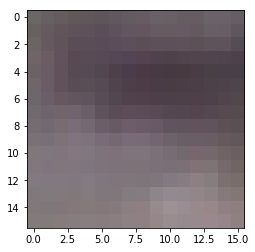

next


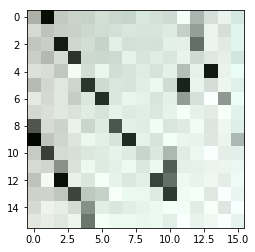

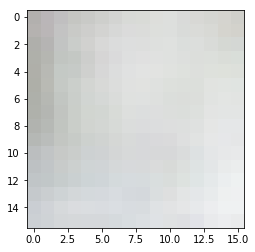

next


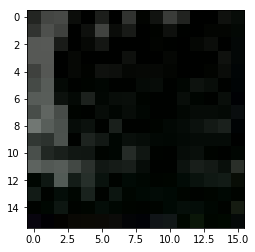

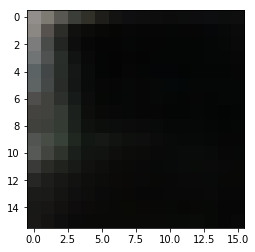

next


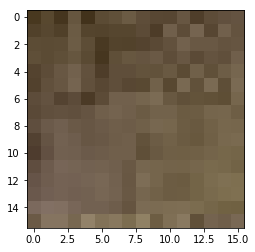

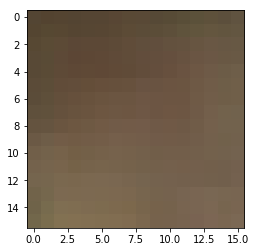

next


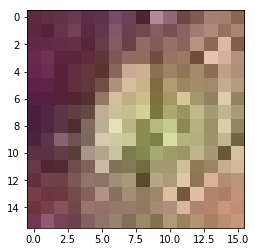

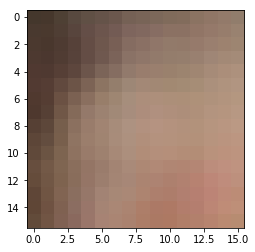

next


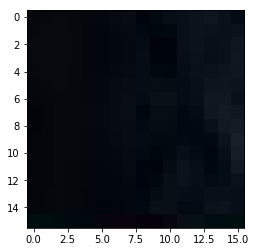

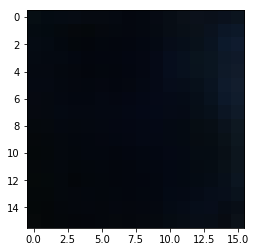

next


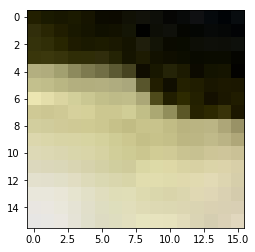

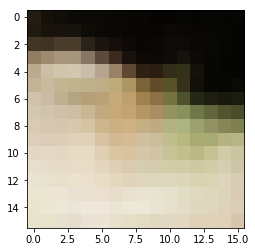

next


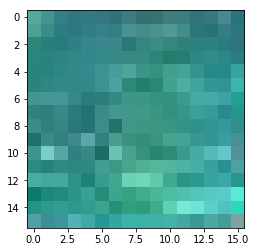

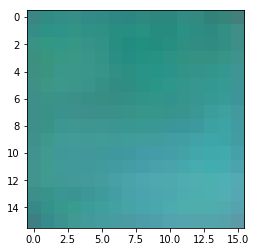

next


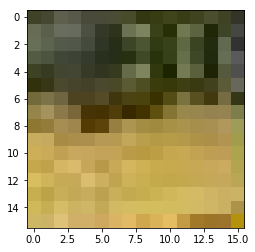

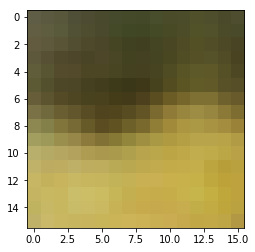

next


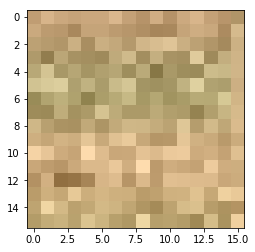

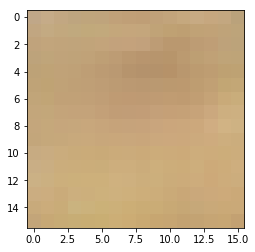

next


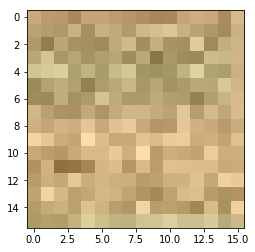

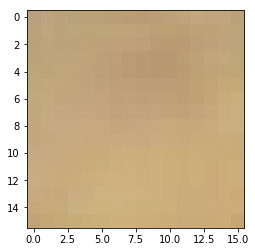

next


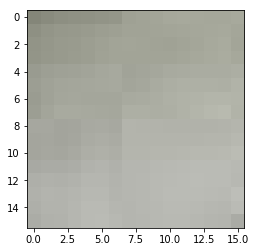

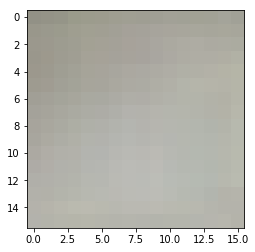

next


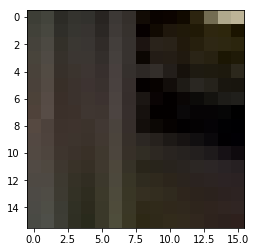

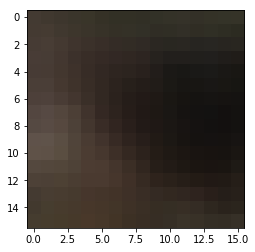

next


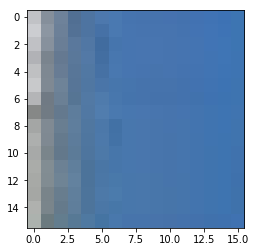

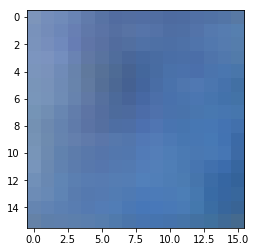

next


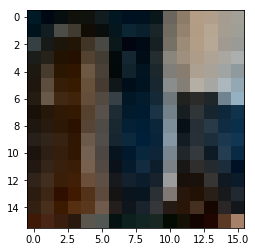

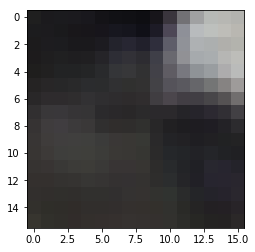

next


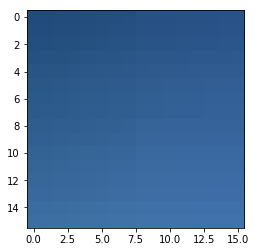

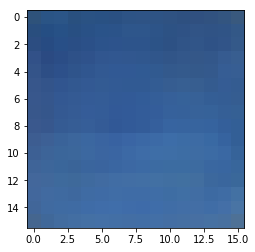

next


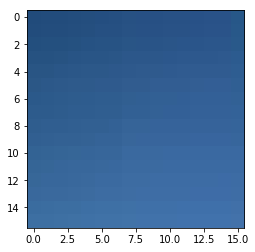

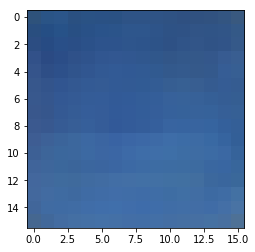

next


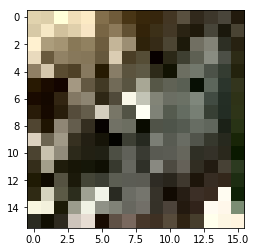

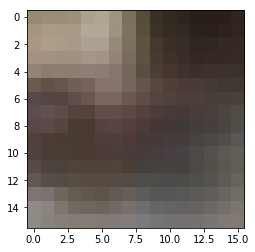

next


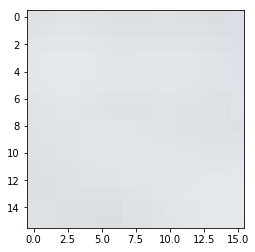

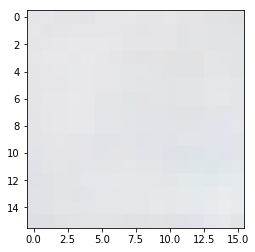

next


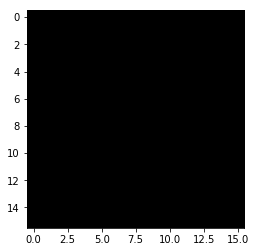

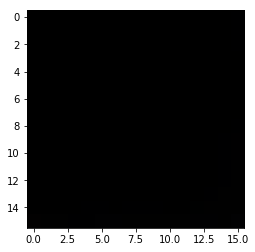

next


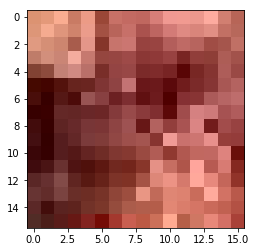

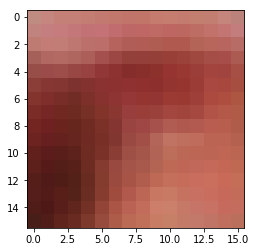

next


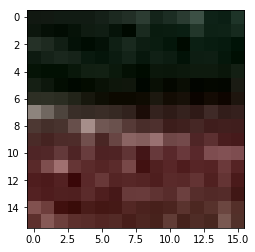

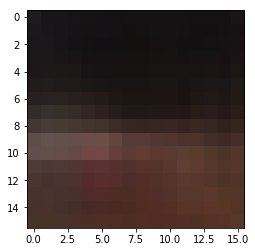

next


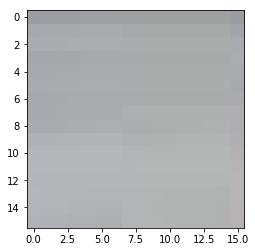

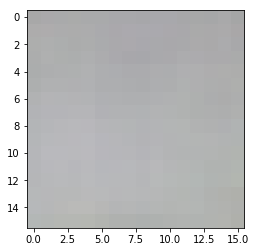

next


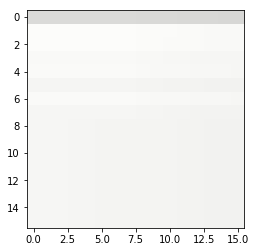

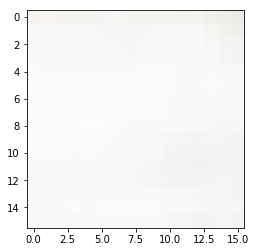

next


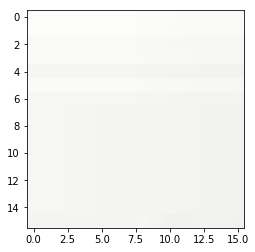

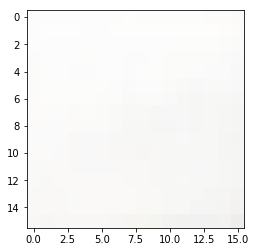

next


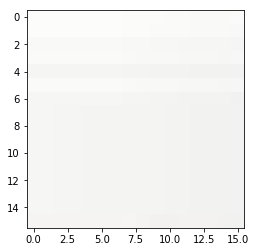

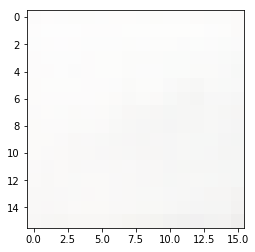

next


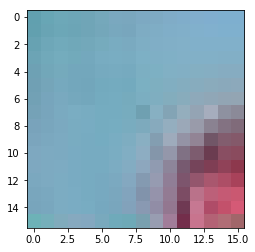

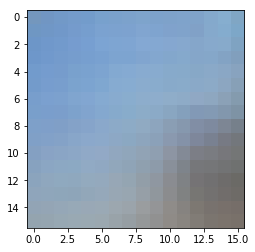

next


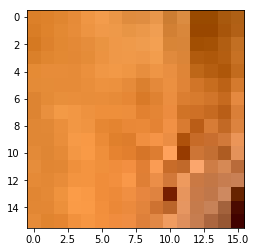

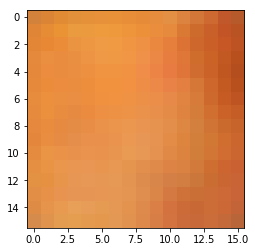

next


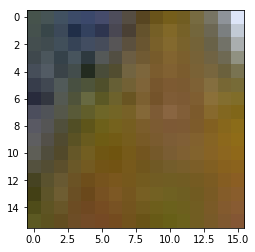

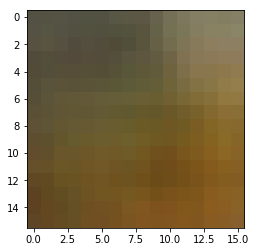

next


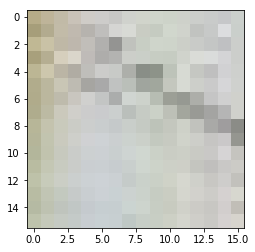

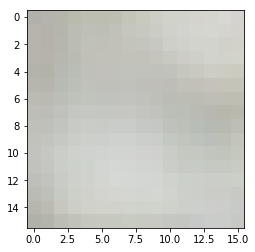

next


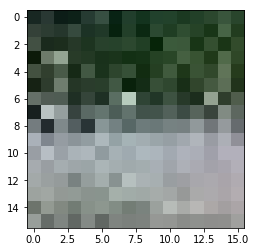

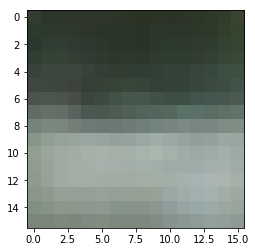

next


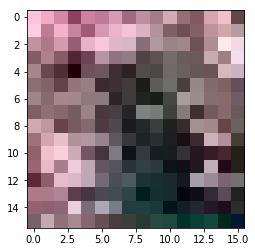

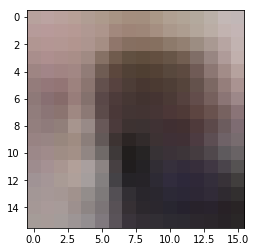

next


In [17]:
images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(img_width, img_height))
        x = img_to_array(img)
        
        x = np.expand_dims(x, axis=0)
        images.append(x)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images /= 255
predictions = autoencoder.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1, interpolation='nearest')
    plt.show()
    
    pred_1 = predictions[i].reshape(input_shape)
    plt.imshow(pred_1, interpolation='nearest')
    plt.show()
    
    print("next")


In [18]:
encoder = Model(input_img, encoded)
encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
for i in range(len(encoder.layers)):
    encoder.get_layer(index=i).set_weights(autoencoder.get_layer(index=i).get_weights())
    
encoder.summary()

encoder.save(base_dir + '/encoder' + model_version + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 2, 2, 32)          0         
__________

In [19]:
code_shape = (16, 1, 1)

images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
#     if counter > 100:
#         break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(img_width, img_height))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images.append(x)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2]) #img_width, img_height, 3
images /= 255
predictions = encoder.predict_on_batch(np.array(images))
# print("predictions: ")

# for i, im1 in enumerate(images):
#     im_1 = im1.reshape(input_shape)
#     plt.imshow(im_1, interpolation='nearest')
#     plt.show()
    
#     pred_1 = predictions[i].reshape(code_shape)
#     plt.imshow(pred_1, interpolation='nearest')
#     plt.show()
    
#     print("next")

In [20]:
images.shape

(3924, 16, 16, 3)

In [21]:
predictions.shape

(3924, 1, 1, 16)

In [22]:
# part 3 - calculating corelation between originals and codes

def patch_diff(patch_1, patch_2):
    if patch_1.shape != patch_2.shape:
        print("Patches don't have the same shape.")
        return
    height = patch_1.shape[0]
    width = patch_1.shape[1]
    nr_channels = patch_1.shape[2]
    ssd = 0
    for i in range(height):
        for j in range (width):
            for k in range(nr_channels):
                #diff = patch_1[i][j][k] - patch_2[i][j][k]
                diff = patch_1[i,j,k] - patch_2[i,j,k]
                ssd += diff * diff
    return ssd

In [23]:
test_data = images
code_data = predictions

nb_originals = test_data.shape[0] #150 #
nb_codes     = code_data.shape[0] #150 #

diff_matrix = np.zeros((nb_originals, nb_originals, 2))

for i in range(nb_originals):
    print("i = " + str(i))
    for j in range(nb_originals):
        #print("    j = " + str(j))
        if i == j:
            continue
        original1 = test_data[i] * 255
        original2 = test_data[j] * 255
        code1 = code_data[i] * 255
        code2 = code_data[j] * 255
        
        originals_diff = np.sum((original1[:,:,:]-original2[:,:,:])**2)
        codes_diff = np.sum((code1[:,:,:]-code2[:,:,:])**2)
        diff_matrix[i,j, 0] = originals_diff
        diff_matrix[i,j, 1] = codes_diff

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 13

i = 1036
i = 1037
i = 1038
i = 1039
i = 1040
i = 1041
i = 1042
i = 1043
i = 1044
i = 1045
i = 1046
i = 1047
i = 1048
i = 1049
i = 1050
i = 1051
i = 1052
i = 1053
i = 1054
i = 1055
i = 1056
i = 1057
i = 1058
i = 1059
i = 1060
i = 1061
i = 1062
i = 1063
i = 1064
i = 1065
i = 1066
i = 1067
i = 1068
i = 1069
i = 1070
i = 1071
i = 1072
i = 1073
i = 1074
i = 1075
i = 1076
i = 1077
i = 1078
i = 1079
i = 1080
i = 1081
i = 1082
i = 1083
i = 1084
i = 1085
i = 1086
i = 1087
i = 1088
i = 1089
i = 1090
i = 1091
i = 1092
i = 1093
i = 1094
i = 1095
i = 1096
i = 1097
i = 1098
i = 1099
i = 1100
i = 1101
i = 1102
i = 1103
i = 1104
i = 1105
i = 1106
i = 1107
i = 1108
i = 1109
i = 1110
i = 1111
i = 1112
i = 1113
i = 1114
i = 1115
i = 1116
i = 1117
i = 1118
i = 1119
i = 1120
i = 1121
i = 1122
i = 1123
i = 1124
i = 1125
i = 1126
i = 1127
i = 1128
i = 1129
i = 1130
i = 1131
i = 1132
i = 1133
i = 1134
i = 1135
i = 1136
i = 1137
i = 1138
i = 1139
i = 1140
i = 1141
i = 1142
i = 1143
i = 1144
i = 1145
i = 1146
i

i = 1948
i = 1949
i = 1950
i = 1951
i = 1952
i = 1953
i = 1954
i = 1955
i = 1956
i = 1957
i = 1958
i = 1959
i = 1960
i = 1961
i = 1962
i = 1963
i = 1964
i = 1965
i = 1966
i = 1967
i = 1968
i = 1969
i = 1970
i = 1971
i = 1972
i = 1973
i = 1974
i = 1975
i = 1976
i = 1977
i = 1978
i = 1979
i = 1980
i = 1981
i = 1982
i = 1983
i = 1984
i = 1985
i = 1986
i = 1987
i = 1988
i = 1989
i = 1990
i = 1991
i = 1992
i = 1993
i = 1994
i = 1995
i = 1996
i = 1997
i = 1998
i = 1999
i = 2000
i = 2001
i = 2002
i = 2003
i = 2004
i = 2005
i = 2006
i = 2007
i = 2008
i = 2009
i = 2010
i = 2011
i = 2012
i = 2013
i = 2014
i = 2015
i = 2016
i = 2017
i = 2018
i = 2019
i = 2020
i = 2021
i = 2022
i = 2023
i = 2024
i = 2025
i = 2026
i = 2027
i = 2028
i = 2029
i = 2030
i = 2031
i = 2032
i = 2033
i = 2034
i = 2035
i = 2036
i = 2037
i = 2038
i = 2039
i = 2040
i = 2041
i = 2042
i = 2043
i = 2044
i = 2045
i = 2046
i = 2047
i = 2048
i = 2049
i = 2050
i = 2051
i = 2052
i = 2053
i = 2054
i = 2055
i = 2056
i = 2057
i = 2058
i

i = 2859
i = 2860
i = 2861
i = 2862
i = 2863
i = 2864
i = 2865
i = 2866
i = 2867
i = 2868
i = 2869
i = 2870
i = 2871
i = 2872
i = 2873
i = 2874
i = 2875
i = 2876
i = 2877
i = 2878
i = 2879
i = 2880
i = 2881
i = 2882
i = 2883
i = 2884
i = 2885
i = 2886
i = 2887
i = 2888
i = 2889
i = 2890
i = 2891
i = 2892
i = 2893
i = 2894
i = 2895
i = 2896
i = 2897
i = 2898
i = 2899
i = 2900
i = 2901
i = 2902
i = 2903
i = 2904
i = 2905
i = 2906
i = 2907
i = 2908
i = 2909
i = 2910
i = 2911
i = 2912
i = 2913
i = 2914
i = 2915
i = 2916
i = 2917
i = 2918
i = 2919
i = 2920
i = 2921
i = 2922
i = 2923
i = 2924
i = 2925
i = 2926
i = 2927
i = 2928
i = 2929
i = 2930
i = 2931
i = 2932
i = 2933
i = 2934
i = 2935
i = 2936
i = 2937
i = 2938
i = 2939
i = 2940
i = 2941
i = 2942
i = 2943
i = 2944
i = 2945
i = 2946
i = 2947
i = 2948
i = 2949
i = 2950
i = 2951
i = 2952
i = 2953
i = 2954
i = 2955
i = 2956
i = 2957
i = 2958
i = 2959
i = 2960
i = 2961
i = 2962
i = 2963
i = 2964
i = 2965
i = 2966
i = 2967
i = 2968
i = 2969
i

i = 3771
i = 3772
i = 3773
i = 3774
i = 3775
i = 3776
i = 3777
i = 3778
i = 3779
i = 3780
i = 3781
i = 3782
i = 3783
i = 3784
i = 3785
i = 3786
i = 3787
i = 3788
i = 3789
i = 3790
i = 3791
i = 3792
i = 3793
i = 3794
i = 3795
i = 3796
i = 3797
i = 3798
i = 3799
i = 3800
i = 3801
i = 3802
i = 3803
i = 3804
i = 3805
i = 3806
i = 3807
i = 3808
i = 3809
i = 3810
i = 3811
i = 3812
i = 3813
i = 3814
i = 3815
i = 3816
i = 3817
i = 3818
i = 3819
i = 3820
i = 3821
i = 3822
i = 3823
i = 3824
i = 3825
i = 3826
i = 3827
i = 3828
i = 3829
i = 3830
i = 3831
i = 3832
i = 3833
i = 3834
i = 3835
i = 3836
i = 3837
i = 3838
i = 3839
i = 3840
i = 3841
i = 3842
i = 3843
i = 3844
i = 3845
i = 3846
i = 3847
i = 3848
i = 3849
i = 3850
i = 3851
i = 3852
i = 3853
i = 3854
i = 3855
i = 3856
i = 3857
i = 3858
i = 3859
i = 3860
i = 3861
i = 3862
i = 3863
i = 3864
i = 3865
i = 3866
i = 3867
i = 3868
i = 3869
i = 3870
i = 3871
i = 3872
i = 3873
i = 3874
i = 3875
i = 3876
i = 3877
i = 3878
i = 3879
i = 3880
i = 3881
i

In [24]:
# has to be square matrix so that the dimension of the list is right,
# otherwise applicable to non-square matrices

def save_below_diagonal_to_list(square_matrix):
    dimension = square_matrix.shape[0]
    return_list = np.zeros((dimension * (dimension - 1)) // 2)
    counter = 0
    for i in range(dimension):
        for j in range(dimension):
            if i > j:
                return_list[counter] = square_matrix[i, j]
                counter += 1
            
    return return_list

In [25]:
originals_diff_matrix = diff_matrix[:,:,0]
codes_diff_matrix = diff_matrix[:,:,1]

originals_diff_matrix_below_diag = save_below_diagonal_to_list(originals_diff_matrix)
codes_diff_matrix_below_diag = save_below_diagonal_to_list(codes_diff_matrix)

In [26]:
np.corrcoef(originals_diff_matrix_below_diag, codes_diff_matrix_below_diag)

array([[1.        , 0.66362172],
       [0.66362172, 1.        ]])

CPU times: user 178 ms, sys: 85.3 ms, total: 263 ms
Wall time: 261 ms


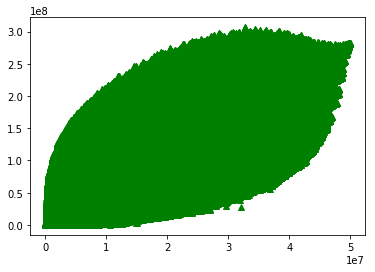

In [27]:
%time plt.plot(originals_diff_matrix_below_diag, codes_diff_matrix_below_diag, 'g^')
plt.show()